In [1]:
import ollama

import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures, TrigramCollocationFinder, TrigramAssocMeasures

from reco_systems.filter import filter_df
import reco_systems.text_filtering as ft
from reco_systems.user_game_matrix import *
from reco_systems.CF_knn import *
from reco_systems.evaluation import *

from surprise import NMF
from surprise import Dataset
from surprise.reader import Reader
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances

from IPython.core.display import display, HTML
import textwrap # to avoid scrolling on long strings in jupyter
#%load_ext autoreload
#%autoreload 2
%matplotlib inline


/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_2695/3278653227.py:25: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [2]:
folder = "../database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", index_col=0)

min_reviews = 10 
rev_filter = filter_df(avis_clean, min_reviews)
games_means = rev_filter[["Game id", "Rating"]].groupby("Game id").mean().reset_index()

rev_filter = rev_filter.assign(index=np.arange(0, rev_filter.shape[0]))
rev_filter_center, _= center_score(rev_filter)

11201 10549
2252 2676
1957 2618
1947 2616
1946 2615
1945 2614


In [3]:
lemmas = pd.read_csv("../generated_data/Lemmas_VER_cleaned.csv", index_col=0)
lemmas = lemmas[~lemmas["Lemma"].isna()]
comment_lemmatized = lemmas.groupby("Comment line")["Lemma"].apply(" ".join).reset_index()
comment_lemmatized = comment_lemmatized.merge(rev_filter[["Game id", "User id"]], left_on="Comment line", right_index=True)
comment_lemmatized

,Comment line,Lemma,Game id,User id
0,0,voyage aile papillon lorsque jeu jeu bon refle...,6179,0
1,1,festival comment continuer apres mega hit simp...,6179,1
2,2,vivre migration monarque vin jeu mariposer par...,6179,2
3,3,manquer peu souffle mariposer plutot beau gran...,6179,3
4,4,beau doux rapide mariposer jeu tension aller c...,6179,4
...,...,...,...,...
94686,142459,piou boum badaboum crac re piou petit jeu bien...,6025,128
94687,142460,star wars revisiter jeu vaisseau spaciaux asse...,6025,7597
94688,142461,piou piou mag blast jeu rapide drole sans pret...,6025,4560
94689,142462,mort ne pouvoir jouer moyen pas pouvoir fouill...,6025,3346


In [4]:
rev_filter = rev_filter[["User id", "Game id", "Comment body", "Rating"]]
rev_filter["Comment length"] = rev_filter["Comment body"].str.split().apply(len)

### Summarizing game/user comments 

In [50]:
def assign_batch_number(df, max_length):
    batch_number = 0
    current_length = 0
    batch_numbers = []

    for length in df['Comment length']:
        if current_length + length > max_length:
            batch_number += 1
            current_length = 0  # Reset the current length
        batch_numbers.append(batch_number)
        current_length += length

    return batch_numbers

def call_model_by_batch(comments_batched:pd.DataFrame, prompt_type:str) -> str:
    # prompt_type = "user", "game"
    prompt_types = {
        "user" : f"""You will receive multiple comments from a single user about different board games.
        These comments are in French and are separated by newlines.
        Your goal is to summarize the user’s overall preferences by identifying what they liked and disliked across all the games.""",

        "game" : f"""You will receive multiple comments from different users about a single board game.
        These comments are in French and are separated by newlines.
        Your goal is to summarize the game's overall strengths and weaknesses based on these comments
        """
                # "user": f"""Un utilisateur a donné plusieurs commentaires sur différents jeux. Je vais te donner ces commentaires.
        #         Ton objectif est de faire un résumé en identifiant ce que cet utilisateur aime et n'aime pas. 
        #         Donne une réponse sous cette forme : 
        #         - Points positifs : (ce que l'utilisateur aime) 
        #         - Points négatifs : (ce que l'utilisateur n'aime pas)

        #         Les commentaires sont séparés par un retour à la ligne (\n) :
        #         """,
        
        # "game": f"""Je vais te donner des commentaires sur un jeu donnés par des différents utilisateurs.
        # Ton objectif est de résumer ces commentaires en identifiant les points positifs et négatifs de ce jeu.

        # Donne une réponse sous cette forme : 
        #         - Points positifs : (ce que l'utilisateur aime) 
        #         - Points négatifs : (ce que l'utilisateur n'aime pas)

        #         Les commentaires sont séparés par un retour à la ligne (\n) :
        
    }
    prompt = prompt_types[prompt_type]
    messages = [{"role": "user", "content": prompt + comments_batched[0]}]
    messages += [{"role":"user", "content":comments_batched[i]} for i in range(1, len(comments_batched))]
    print(len(messages))
    response = ollama.chat(model='llama3.2', messages=messages)
    return response['message']['content']

def calc_nb_words(comments:pd.DataFrame) -> int:
    return comments.str.split().explode().size

#### Number of reviews per user

In [52]:

users_count = rev_filter.groupby("User id").agg(count=('Game id', 'count'), mean=('Rating', 'mean')).reset_index().sort_values(by="mean").head(30)
games_count = rev_filter.groupby("Game id").agg(count=('User id', 'count'), mean=('Rating', 'mean')).reset_index().sort_values(by="mean").tail(30)

users_styler = users_count.style.set_table_attributes("style='display:inline'").set_caption('Users count reviews, mean rating')
games_styler = games_count.style.set_table_attributes("style='display:inline'").set_caption('Users count reviews, mean rating')
    
display_html(users_styler._repr_html_()+games_styler._repr_html_(), raw=True)

,User id,count,mean
491,1474,13,3.500000
1281,3683,43,4.139535
432,1207,41,4.141463
1714,5625,10,4.160000
1827,6888,12,4.500000
1664,5196,12,4.500000
66,111,119,4.554622
1735,6078,10,4.600000
1569,4730,11,4.727273
274,614,39,4.782051


### User's comments

**User with 1111 (sample 700) reviews and mean rating : 6.68**

In [51]:
np.random.seed(42)
user = 208
user_comments = rev_filter[rev_filter["User id"] == user].sample(700) # Sample 700 comments
user_comments = user_comments.assign(Batch=assign_batch_number(user_comments, 2300))
user_comments_batched = user_comments.groupby("Batch")["Comment body"].apply("\n".join).tolist()
print("Nb words:", calc_nb_words(user_comments["Comment body"]))
response = call_model_by_batch(user_comments_batched, "user")
print("\n".join(textwrap.fill(word, width=100) for word in response.split('\n')))

Nb words: 52970
24
Il semble que vous ayez collecté des évaluations de plusieurs jeux de société, mais sans fournir un
contexte précis sur lesquels vous souhaitez discuter ou quel genre de jeu vous souhaitez aborder en
particulier. Cependant, je vais essayer de synthétiser les points positifs et négatifs pour les
différents jeux mentionnés.

**Généralités**

- Les évaluations indiquent que de nombreux jeux proposent des règles simples à expliquer et un
matériel de qualité.
- La plupart des jeux sont jugés favorables en termes d'ambiance, de gameplay original ou innovant,
et de répertoire de cartes diversifié.

**Conseils généraux**

1. **Choix du jeu :** Il est important de choisir un jeu qui convient à votre groupe et à vos
intérêts. Les jeux qui proposent des règles simples sont souvent plus accessibles aux nouveaux
joueurs, mais ceux avec des mécaniques complexes peuvent offrir une expérience plus riche pour les
amateurs confirmés.

2. **Matériel de qualité :** La qualité du matérie

**User with 403 reviews and mean rating : 8.61**

In [56]:
user = 2747
user_comments = rev_filter[rev_filter["User id"] == user]
user_comments = user_comments.assign(Batch=assign_batch_number(user_comments, 2300))
user_comments_batched = user_comments.groupby("Batch")["Comment body"].apply("\n".join).tolist()
print("Nb words:", calc_nb_words(user_comments["Comment body"]))
response = call_model_by_batch(user_comments_batched, "user")
print("\n".join(textwrap.fill(word, width=100) for word in response.split('\n')))

Nb words: 55426
26
Je vais résumer les avis que vous avez lus sur ce jeu de société :

**Avantages :**

* Le jeu est simple à expliquer et à comprendre
* Les pièces et le matériel sont belles et bien faites
* Le jeu est interactif et encourage la pensée stratégique
* Il est possible de jouer avec 2 ou plus de joueurs

**Inconvénients :**

* Le jeu peut être trop prévisible, ce qui peut rendre l'expérience moins excitante
* Les constantes du jeu doivent être vérifiées en permanence pour éviter de progresser trop vite
* Il est difficile de contrôler certaines actions pendant le jeu
* La stratégie n'est pas toujours claire

**Opinions :**

* Les joueurs ont apprécié la simplicité et l'interaction du jeu
* Le jeu est bien pour les enfants, mais peut ne pas être suffisamment défiant pour les adultes
* Certains joueurs ont apprécié le coup du sac à dos et le principe de jeu
* D'autres ont trouvé que le jeu était trop prévisible et qu'il manquait de stratégie

**Note :**

* Les avis varient, 

**User with 180 reviews and mean ratings : 5.47**

In [55]:
user = 3428
user_comments = rev_filter[rev_filter["User id"] == user]
user_comments = user_comments.assign(Batch=assign_batch_number(user_comments, 2300))
user_comments_batched = user_comments.groupby("Batch")["Comment body"].apply("\n".join).tolist()
print("Nb words:", calc_nb_words(user_comments["Comment body"]))
response = call_model_by_batch(user_comments_batched, "user")
print("\n".join(textwrap.fill(word, width=100) for word in response.split('\n')))

Nb words: 9047
5
Il semble que vous ayez joué à différents jeux de cartes qui partagent certains caractéristiques
similaires. Voici une analyse détaillée de chaque jeu mentionné, basée sur votre description :

1. **Jeux de rami (ou Rami)** : Ce type de jeu implique souvent des actions stratégiques et
tactiques liées à la manipulation des cartes. Le fait que les joueurs soient disposés suivant leur
rang peut ajouter une dimension de compétition et d'humour au jeu, notamment lorsqu'il s'agit du
dernier joueur qui doit assier sur le "moins bon siège". Le rami est un type de jeu de cartes
classique où chaque joueur cherche à éliminer les autres en utilisant des cartes spécifiques ou en
réalisant des actions stratégiques.

2. **Jeux d'adresse** : Les jeux d'adresse sont connus pour leur élément de chance et de réflexion
rapide, qui nécessite une observation aiguë et une réaction rapide du joueur. La mention "Attention
aux yeux !" suggère que ce jeu met à l'épreuve la capacité à observer et 

### Game's comments

**Game with X reviews and mean rating : X**

In [ ]:
game = 7733
game_comments = rev_filter[rev_filter["Game id"] == game]
game_comments = game_comments.assign(Batch=assign_batch_number(game_comments, 1500))
game_comments_batched = game_comments.groupby("Batch")["Comment body"].apply("\n".join).tolist()
print("Nb words:", calc_nb_words(game_comments["Comment body"]))
response = call_model_by_batch(game_comments_batched, "game")
print("\n".join(textwrap.fill(word, width=100) for word in response.split('\n')))

1791

In [128]:
response = call_model_by_batch(game_comments_batched, "game")
print(response)

2
Cette extension pour le jeu Rallyman est une véritable ode aux fans du rally. Elle apporte de nombreuses nouvelles fonctionnalités qui en font un ajout indispensable au jeu.

La première chose à noter est la qualité des nouvelles règles et de l'extension elle-même, qui sont vraiment bien écrites et faciles à comprendre. L'auteur a effectué une bonne analyse du gameplay original pour proposer des modifications qui améliorent encore le plaisir de jouer.

L'une des innovations les plus intéressantes est le système de choix de pneus, qui permet aux joueurs de prendre en compte la condition de la piste et leur propre style de conduite. Ce système est vraiment bien pensé et ajoute une dimension tactique au jeu qui n'était pas présente jusqu'à présent.

Les nouveaux terrains, les dés, les tableaux de bord dynamiques sont également très bien ajoutés. Ils apportent un élément de surprise et de complexité à la partie, ce qui rend le jeu encore plus passionnant.

On remarque également que l'aut

### Comments embeddings per cluster

In [16]:
model = NMF(n_factors=20, random_state=42, biased=False, reg_pu= 0.1, reg_qi= 0.1)
data = Dataset.load_from_df(rev_filter[["User id", "Game id", "Rating"]], reader=Reader(rating_scale=(0, 10)))
trainset = data.build_full_trainset()
nmf = model.fit(trainset)

# Extract matrices
U = nmf.pu  # User-feature matrix (W)
G = nmf.qi  # Item-feature matrix (H)

games_ids = np.array([trainset.to_raw_iid(i) for i in range(len(G))])
users_ids = np.array([trainset.to_raw_uid(u) for u in range(len(U))])
G = G[np.argsort(games_ids), :]

NB_CLUSTERS = 30
kmeans = KMeans(n_clusters=NB_CLUSTERS, random_state=42) 
kmeans.fit(G) 

games_clusters = pd.DataFrame(data={"Game id":games_ids, "Cluster":kmeans.labels_})

#### Embeddings on comments per clusters

##### Select only comments with $10$ to $300$ words

In [17]:
rev_filter = rev_filter.assign(index=rev_filter.index)

In [43]:
rev_filter_limit = rev_filter[(rev_filter["Comment length"] > 10) & (rev_filter["Comment length"] < 300)]
comment_lemmatized_limit = comment_lemmatized[comment_lemmatized["Comment line"].isin(rev_filter_limit["index"])].rename(columns={"Lemma":"Comment body"})
comment_lemmatized_limit

,Comment line,Comment body,Game id,User id
0,0,voyage aile papillon lorsque jeu jeu bon refle...,6179,0
1,1,festival comment continuer apres mega hit simp...,6179,1
2,2,vivre migration monarque vin jeu mariposer par...,6179,2
3,3,manquer peu souffle mariposer plutot beau gran...,6179,3
4,4,beau doux rapide mariposer jeu tension aller c...,6179,4
...,...,...,...,...
94686,142459,piou boum badaboum crac re piou petit jeu bien...,6025,128
94687,142460,star wars revisiter jeu vaisseau spaciaux asse...,6025,7597
94688,142461,piou piou mag blast jeu rapide drole sans pret...,6025,4560
94689,142462,mort ne pouvoir jouer moyen pas pouvoir fouill...,6025,3346


In [44]:
def find_represent_comment(cluster, games_clusters, rev_filter):
    # all comment per cluster
    comments_cluster = games_clusters[games_clusters["Cluster"] == cluster].merge(rev_filter, on="Game id")
    print("Nb comments :", comments_cluster.shape[0])
    embeddings = []
    for comment in comments_cluster["Comment body"]:
        response =  ollama.embeddings(model="paraphrase-multilingual", prompt=comment)
        embeddings.append(response["embedding"])
    
    embeddings = np.array(embeddings)
    mean_comment = embeddings.mean(axis=0) 

    # Find closest existing comment 
    dist = cosine_distances(mean_comment.reshape(1, -1), embeddings)

    return comments_cluster, embeddings,  dist.flatten()

def plot_bigrams(comments_selected):
    print("Comments selected :", comments_selected.size)
    bigrams = BigramCollocationFinder.from_documents(comments_selected.str.split().tolist())
    bigrams_freq = bigrams.score_ngrams(BigramAssocMeasures.raw_freq)

    bigrams_df = pd.DataFrame(data=[list(info) for info in bigrams_freq])

    bigrams_df[0] = bigrams_df[0].apply(list).apply(" ".join)
    bigrams_df = bigrams_df.rename(columns={0:"Lemma", 1:"Freq"})

    sns.set_theme(rc={"figure.figsize":(15, 6)})
    ax = sns.barplot(data=bigrams_df.sort_values(by="Freq", ascending=False).head(100), y="Freq", x="Lemma")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90); # ; to avoid printing return value

**Worst rated cluster**

Nb comments : 2942
Comments selected : 5


/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_12757/311390594.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90); # ; to avoid printing return value


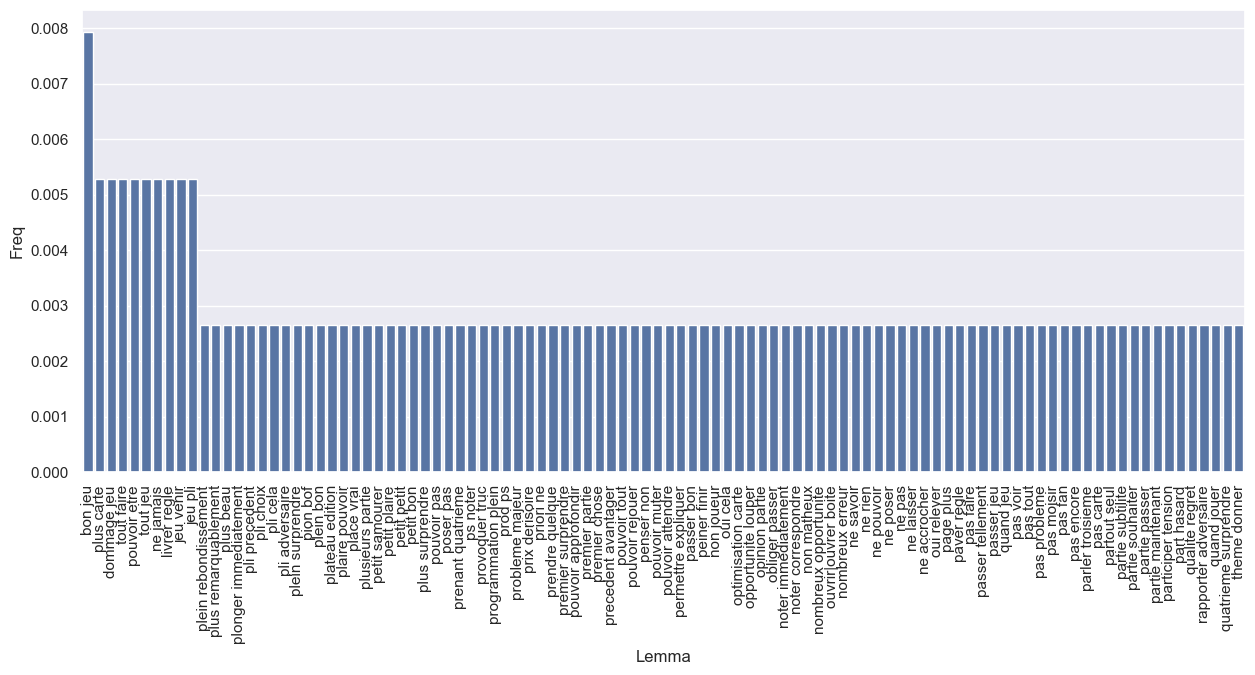

In [ ]:
CLUSTER=10
PERC = 1.10 # percentage of autorized distance higher than min distance
comments_cluster, embeddings, dist = find_represent_comment(CLUSTER, games_clusters, comment_lemmatized_limit)

dist_min = np.min(dist)
closest = np.argwhere(dist <= dist_min * PERC).flatten()
print(dist[closest])
plot_bigrams(comments_cluster.loc[closest, "Comment body"])
print(textwrap.fill(rev_filter_limit.iloc[np.argmin(dist)]["Comment body"], width=80))

**Best rated cluster**

Nb comments : 3796
Comments selected : 6


/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_12757/311390594.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90); # ; to avoid printing return value


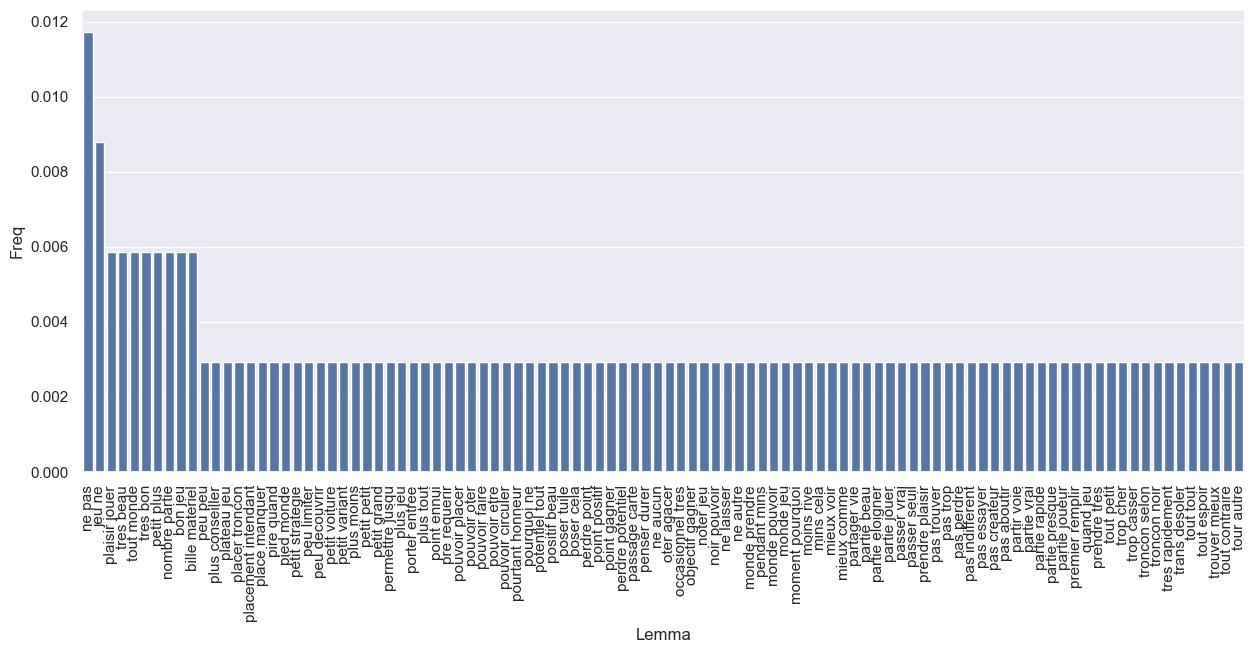

In [ ]:
CLUSTER=24
PERC = 1.10
comments_cluster, embeddings, dist = find_represent_comment(CLUSTER, games_clusters, comment_lemmatized_limit)

dist_min = np.min(dist)
closest = np.argwhere(dist <= dist_min * PERC).flatten()
print(dist[closest])
plot_bigrams(comments_cluster.loc[closest, "Comment body"])
print(textwrap.fill(rev_filter_limit.iloc[np.argmin(dist)]["Comment body"], width=80))

**Dense cluster (TSNE) with *guerre* as dominant tag**

Nb comments : 2894
0.08562086877762387
Comments selected : 17
On adore ce jeu par chez nous, il fonctionne parfaitement à 4 mais peut-être
encore plus à 2. Il assez long (pas loin de trois heures à chaque fois y compris
à deux) mais on ne voit pas le temps passé. Je vous conseil de démarrer toutes
vos productions à 1 sinon c'est 4 heures. Mais la durée fait partie du plaisir,
chaque tour est une génération et blitzer un tel jeu lui fait perdre alors tout
son sens. Il y a bien des jeux que l'on a adoré mais celui ci en plus l'on y
rejoue régulièrement. Il y a pas mal d'extension, Venus next n'apporte pas grand
chose et on est vite revenu au jeu de base.


/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_12757/311390594.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90); # ; to avoid printing return value


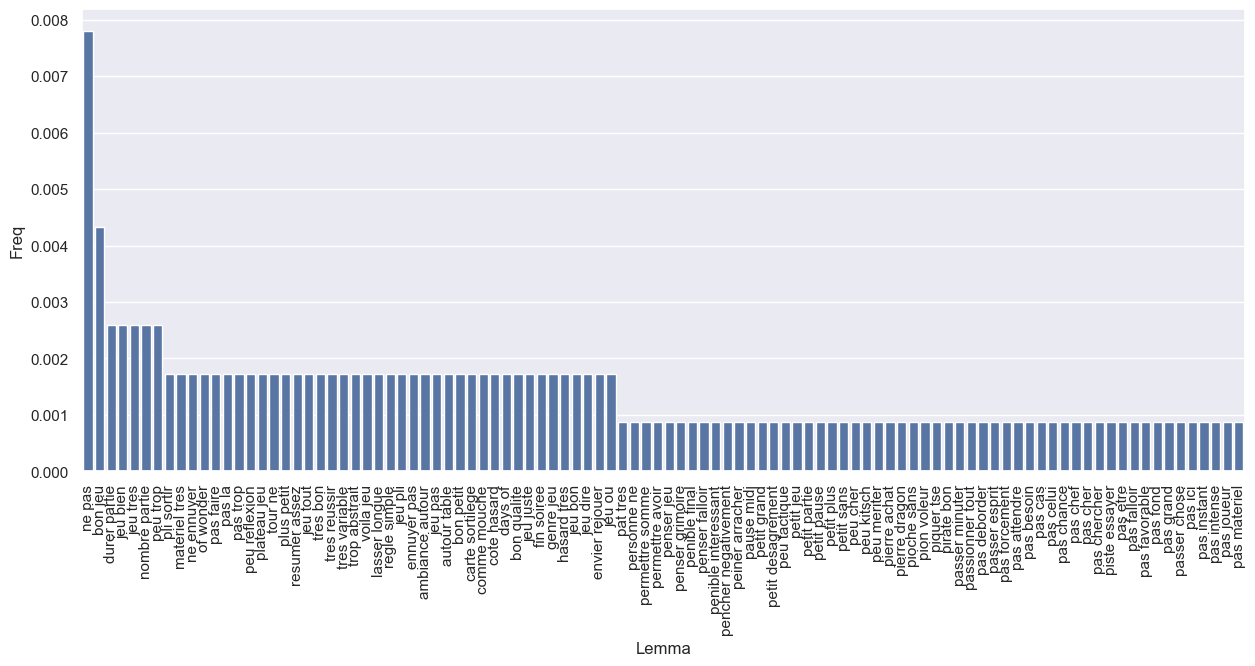

In [60]:
CLUSTER=2
PERC = 1.25
comments_cluster, embeddings, dist = find_represent_comment(CLUSTER, games_clusters, comment_lemmatized_limit)

dist_min = np.min(dist)
closest = np.argwhere(dist <= dist_min * PERC).flatten()
print(dist[closest])
plot_bigrams(comments_cluster.loc[closest, "Comment body"])
print(textwrap.fill(rev_filter_limit.iloc[np.argmin(dist)]["Comment body"], width=80))

**Dense cluster (TSNE) with *jeux de dés* as dominant tag**

Nb comments : 3280
[0.10514013 0.08465603 0.09816631 0.09325839 0.10354588 0.10108817
 0.09200096 0.10119215 0.09676101 0.08895908 0.08482924 0.10016559]
Comments selected : 12
Même si on peut veiller au jeu de ses voisins, il faudra quand même une bonne
dose de chance pour emporter la victoire! Mais c'est amusant, un p'tit jeu
d'apéro à proposer à tout le monde, c'est rapide et efficace!


/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_12757/311390594.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90); # ; to avoid printing return value


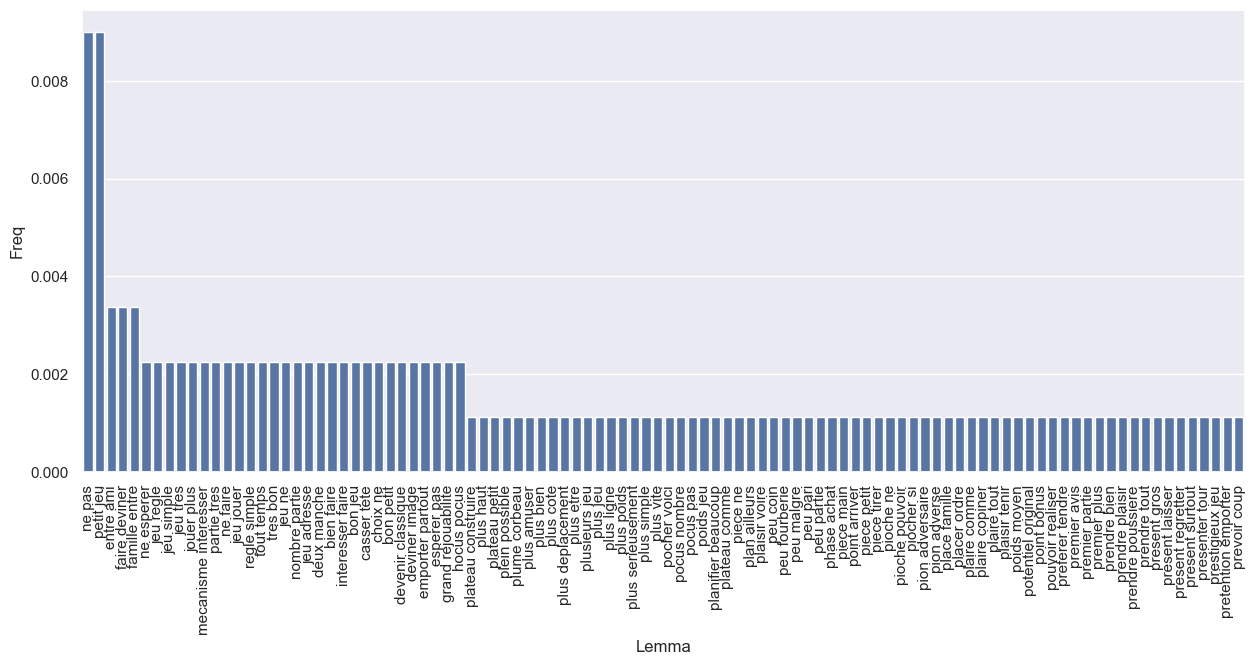

In [70]:
CLUSTER=3
PERC = 1.25
comments_cluster, embeddings, dist = find_represent_comment(CLUSTER, games_clusters, comment_lemmatized_limit)

dist_min = np.min(dist)
closest = np.argwhere(dist <= dist_min * PERC).flatten()
print(dist[closest])
plot_bigrams(comments_cluster.loc[closest, "Comment body"])
print(textwrap.fill(rev_filter_limit.iloc[np.argmin(dist)]["Comment body"], width=80))

**Dense cluster (TSNE) with *transport de marchandise* as dominant tag**

Nb comments : 2530
[0.08593041 0.10383374 0.10191651 0.08369775 0.09655991 0.10104245
 0.09322084 0.10358145]
Comments selected : 8
Un jeu avec la mécanique de Carcassonne mais en plus élaboré à mon goût,
Plaisant


/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_12757/311390594.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90); # ; to avoid printing return value


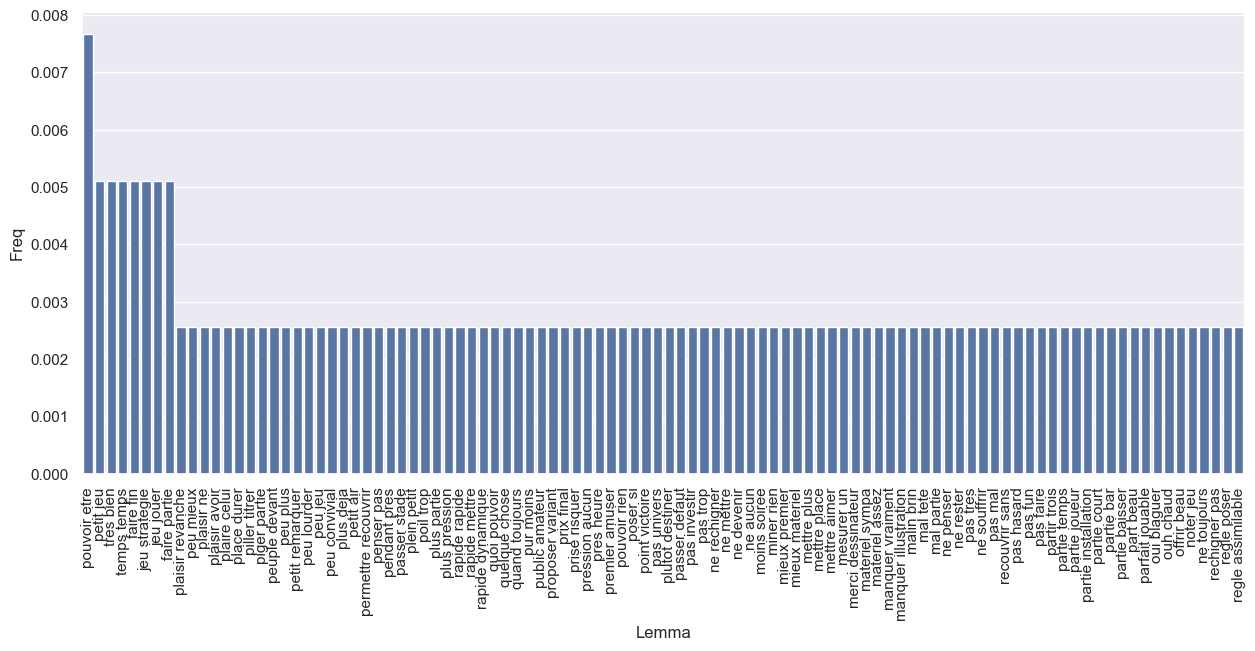

In [64]:
CLUSTER=9
PERC = 1.25
comments_cluster, embeddings, dist = find_represent_comment(CLUSTER, games_clusters, comment_lemmatized_limit)

dist_min = np.min(dist)
closest = np.argwhere(dist <= dist_min * PERC).flatten()
print(dist[closest])
plot_bigrams(comments_cluster.loc[closest, "Comment body"])
print(textwrap.fill(rev_filter_limit.iloc[np.argmin(dist)]["Comment body"], width=80))

In [85]:
words = comment_lemmatized_limit[comment_lemmatized_limit["Game id"].isin(games_clusters[games_clusters["Cluster"] == 3]["Game id"])]["Comment body"].str.split().explode().value_counts()